In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import tifffile
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.neighbors import NearestNeighbors
from autobl.steering import configs, measurement
from autobl import image_proc
from tqdm.notebook import tqdm, trange


In [2]:
# Load the image and initialize the probe
image = tifffile.imread(os.path.join("tests", "data", "xrf", "xrf_2idd_Cs_L.tiff"))  # Load the XRF image data
probe = np.ones((4, 4))  # Initialize a 4x4 probe with all ones (a simple uniform probe)

# Set up the experiment parameters              Yu_Q1: what is the psize_nm size mean?
sample_params = configs.SpatialSampleParams(image=image, psize_nm=1)  # Define spatial sample parameters, including the image and pixel size

setup_params = configs.FlyScanExperimentSetupParams(
    psize_nm=1.0,  # Pixel size in nanometers
    scan_speed_nm_sec=1.0,  # Scanning speed in nanometers per second
    exposure_sec=0.8,  # Exposure time in seconds
    deadtime_sec=0.8,  # Dead time between scans in seconds
    probe=probe,  # Use the initialized probe for the experiment
)

measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,  # Use the defined spatial sample parameters
    setup_params=setup_params,  # Use the defined experimental setup parameters
    step_size_for_integration_nm=0.02,  # Step size for integration in nanometers
)

# Initialize the measurement interface for the FlyScan simulation
measurement_interface = measurement.FlyScanSingleValueSimulationMeasurement(measurement_configs)

# Initialize the reconstructor with Inverse Distance Weighting (IDW) method, using PyTorch as the backend
reconstructor = image_proc.Reconstructor("idw", backend="torch")

In [3]:
# Define the distortion function
def calculate_distortion(image, reconstruction):
    return 0.5 * (image - reconstruction) ** 2

In [4]:
# whole image grid points
y_dense = torch.arange(0.0, image.shape[0], 1)
x_dense = torch.arange(0.0, image.shape[1], 1)
meshgrids_dense = torch.meshgrid(y_dense, x_dense, indexing='ij')
xi = torch.stack(meshgrids_dense, dim=-1).reshape(-1, len(meshgrids_dense))

# initila scan 
y_current = torch.arange(10, image.shape[0] - 10, 1)
x_current = torch.arange(0, image.shape[1], 30)
meshgrids_current = torch.meshgrid(y_current, x_current, indexing='ij')
points_current = torch.stack(meshgrids_current, axis=-1).reshape(-1, len(meshgrids_current))
initial_points = len(points_current)
# # Get the values at the current points from the measurement interface
values_current = torch.tensor(measurement_interface.measure(points_current))

# Retrieve the probe image for comparison
probe_image = measurement_interface.probe_image

# Set n_neighbors to be the minimum of 30 or the number of available points
n_neighbors = min(30, len(points_current))
# Perform the initial reconstruction using the IDW method (1st reconstruction)
recon_current = reconstructor.reconstruct_idw_torch(points_current, values_current, xi=xi, n_neighbors=n_neighbors, power=2) #Yu_Q:how to choose
initial_recon = recon_current.detach().numpy().reshape(meshgrids_dense[0].shape)

# Calculate the distortion between the reconstruction and the probe image
distortion_before = calculate_distortion(initial_recon, probe_image)

# The following variables are now available for further processing or plotting:
# points_current, values_current, probe_image, xi, meshgrids_dense, recon_current, distortion_before

In [5]:
# Compute the acquisition function for uncertainty estimation
def compute_acquisition_function(points, values, xi, nn_inds, reconstructor, sigma=1.0, length=4.0):
    # Perform IDW reconstruction to get the predicted values
    recon_current = reconstructor.reconstruct_idw_torch(points, values, xi=xi, nn_inds=nn_inds, power=2)
    # Calculate the gradient of the reconstruction
    gradient = reconstructor.reconstruct_idw_grad_torch(points, values, xi=xi, nn_inds=nn_inds, power=2)
    gradient_norm = torch.linalg.norm(gradient, axis=0)
    # Estimate uncertainty using the RBF-like uncertainty model
    uncertainty = rbf_uncertainty(points, xi, sigma=sigma, nn_inds=nn_inds, length=length)
    # Combine uncertainty with the gradient norm to form the acquisition function
    acquisition = uncertainty * gradient_norm
    return acquisition 

def rbf_uncertainty(points, xi, sigma=1.0, nn_inds=None, length=4.0):
    if nn_inds is None:
        # Calculate distances if not provided
        square_dists = torch.sum((xi[:, None, :] - points[None, :, :]) ** 2, dim=-1)
    else:
        # Use provided nearest neighbors indices to compute distances
        square_dists = torch.sum((xi[:, None, :] - points[nn_inds]) ** 2, dim=-1)
    # Normalize distances by length scale
    square_dists /= length ** 2
    # Compute softmax weights based on distances
    softmax_weights = torch.softmax(-square_dists, dim=-1)
    # Compute weighted sum of distances to get uncertainty
    uncertainty = sigma**2 * (1 - torch.exp(torch.sum(-softmax_weights * square_dists, axis=-1))) 
    return uncertainty #relation bt loss and distortion
    

In [6]:
# # Perform optimization to reduce acquisition
def optimize_scan_points(points_current, values_current, xi, reconstructor):
    # Generate random scan points for optimization
    points_scan = np.stack((
        np.random.uniform(2, probe_image.shape[0] - 2, size=(2000,)),
        np.random.uniform(2, probe_image.shape[1] - 2, size=(2000,))
    ), axis=-1)
    points_scan = torch.tensor(points_scan, requires_grad=True)

    optimizer = optim.Adam([points_scan], lr=0.01)

    for i in trange(50):
        # Perform pseudo-reconstruction
        pseudo_values_scan = reconstructor.reconstruct_idw_torch(
            points_current, values_current, xi=points_scan, n_neighbors=30, power=2)
        
        # Combine current and pseudo scan points
        points_combined = torch.cat((points_current, points_scan))
        values_combined = torch.cat((values_current, pseudo_values_scan))

        # Compute nearest neighbors for combined points
        knn_engine = NearestNeighbors(n_neighbors=30)
        knn_engine.fit(points_combined.detach().numpy())
        nn_inds = knn_engine.kneighbors(xi, return_distance=False)

        # Compute acquisition function for uncertainty estimation
        acquisition = -compute_acquisition_function(points_combined, values_combined, xi, nn_inds, reconstructor)

        # Backpropagate the uncertainty (used as a loss function here)
        avg_loss = torch.mean(acquisition) # scalar
        avg_loss.backward()  # Uncertainty is minimized
        optimizer.step()

        print(f"Iteration {i}, avg_loss: {avg_loss.item()}", end='\r')
        

    # Convert PyTorch tensors to NumPy arrays
    points_scan_np = points_scan.detach().numpy()
    points_current_np = points_current.detach().numpy()

    # Remove points_current_np from points_scan_np
    # This ensures that any points in points_current_np are excluded from points_scan_np
    filtered_points_scan_np = np.array([p for p in points_scan_np if p.tolist() not in points_current_np.tolist()])

    # Proceed with your operations using `filtered_points_scan_np`
    print(f"Original points_scan: {len(points_scan_np)}")
    print(f"Filtered points_scan (after removing points_current): {len(filtered_points_scan_np)}")


    return filtered_points_scan_np, nn_inds


In [7]:
# Run the process
optimized_scan_points, nn_inds = optimize_scan_points(points_current, values_current, xi, reconstructor)
# len(optimized_scan_points)
print(optimized_scan_points)

  0%|          | 0/50 [00:00<?, ?it/s]

Original points_scan: 2000.2156556101834354
Filtered points_scan (after removing points_current): 2000
[[  8.79961094   2.3011442 ]
 [ 69.43230252  96.6516576 ]
 [ 56.4428962   51.32836672]
 ...
 [ 74.64693939 109.38748242]
 [109.86151034 117.01210106]
 [ 96.33209415  14.15761896]]


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial import distance_matrix

# # Helper function to remove consecutive duplicate points
# def remove_consecutive_duplicates(points):
#     """Remove consecutive duplicate points from a list of points."""
#     unique_points = [points[0]]
#     for i in range(1, len(points)):
#         if not np.allclose(points[i], points[i-1]):
#             unique_points.append(points[i])
#     return unique_points

# # Function to calculate total distance of a path
# def total_distance(path, dist_matrix):
#     dist = 0
#     for i in range(len(path) - 1):
#         dist += dist_matrix[path[i], path[i + 1]]
#     return dist

# # Function to find nearest neighbor path
# def nearest_neighbor_tsp(start_point, dist_matrix):
#     num_points = len(dist_matrix)
#     unvisited = list(range(num_points))
#     path = [start_point]
#     unvisited.remove(start_point)

#     current_point = start_point
#     while unvisited:
#         # Find nearest unvisited neighbor
#         next_point = min(unvisited, key=lambda i: dist_matrix[current_point, i])
#         path.append(next_point)
#         unvisited.remove(next_point)
#         current_point = next_point

#     return path

# # Function for linear interpolation between two points
# def linear_interpolate(p1, p2, num_subpoints=10):
#     """Interpolate between two points with float coordinates."""
#     x_vals = np.linspace(p1[0], p2[0], num_subpoints)
#     y_vals = np.linspace(p1[1], p2[1], num_subpoints)
#     return np.vstack((x_vals, y_vals)).T

# # Set up the simulator
# simulator = measurement.FlyScanSingleValueSimulationMeasurement(measurement_configs)

# # Calculate the distance matrix for the optimized scan points
# dist_matrix = distance_matrix(optimized_scan_points, optimized_scan_points)

# # Define start point and get the TSP path using nearest neighbor heuristic
# start_point = 0
# tsp_path = nearest_neighbor_tsp(start_point, dist_matrix)

# # Collect all the points along the path using interpolation
# all_path_points = []
# for i in range(len(tsp_path) - 1):
#     p1 = optimized_scan_points[tsp_path[i]]
#     p2 = optimized_scan_points[tsp_path[i + 1]]
#     line_points = linear_interpolate(p1, p2, num_subpoints=10)  # Adjust the number of subpoints as needed
#     all_path_points.extend(line_points)

# # Remove consecutive duplicate points from the path
# all_path_points = remove_consecutive_duplicates(optimized_scan_points)

# # Use simulator's measure method to simulate the scan with motion blur
# # all_path_points is the list of vertices (waypoints)
# measured_values = simulator.measure(optimized_scan_points)  # This returns I_hats
# measured_positions = simulator.measured_positions  # This returns r_hats


# # Convert the measured positions into a NumPy array for plotting
# measured_positions = np.array(measured_positions)

# # Plot the measured path
# plt.figure(figsize=(8, 6))

# # Plot the measured TSP path (with motion blur considered)
# plt.plot(measured_positions[:, 0], measured_positions[:, 1], 'r-', lw=1)

# # Plot each point from the original optimized scan points
# for i, (x, y) in enumerate(optimized_scan_points):
#     plt.scatter(x, y, color='blue', s=10)

# # # Add start and end labels
# # plt.scatter(optimized_scan_points[start_point][0], optimized_scan_points[start_point][1], color='green', s=50, label='Start')
# # plt.scatter(optimized_scan_points[tsp_path[-1]][0], optimized_scan_points[tsp_path[-1]][1], color='red', s=50, label='End')

# # Add title and legend
# plt.title('Measured Positions Path (Motion Blur Considered)')
# plt.legend()
# plt.show()

# # Print the number of unique points along the path (measured positions)
# total_points_in_path = len(measured_positions)
# print(f"Total unique measured points along the path: {total_points_in_path}")




In [9]:
#print(len(measured_positions))

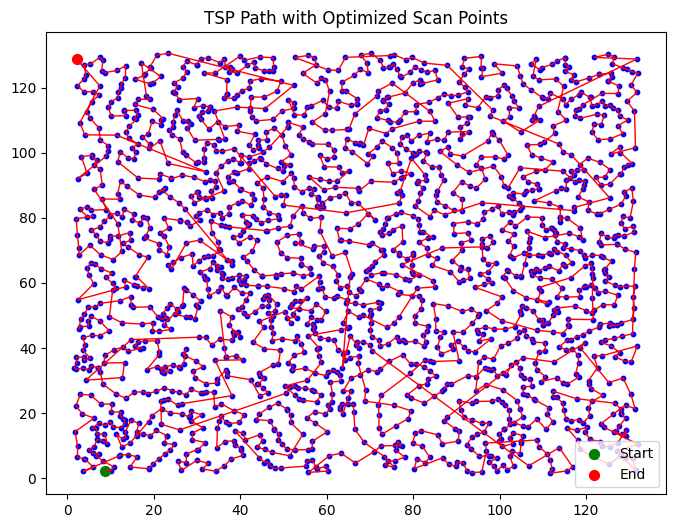

Total unique points in the path: 19990


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Function to calculate total distance of a path
def total_distance(path, dist_matrix):
    dist = 0
    for i in range(len(path) - 1):
        dist += dist_matrix[path[i], path[i + 1]]
    return dist

# Function to find nearest neighbor path
def nearest_neighbor_tsp(start_point, dist_matrix):
    num_points = len(dist_matrix)
    unvisited = list(range(num_points))
    path = [start_point]
    unvisited.remove(start_point)

    current_point = start_point
    while unvisited:
        # Find nearest unvisited neighbor
        next_point = min(unvisited, key=lambda i: dist_matrix[current_point, i])
        path.append(next_point)
        unvisited.remove(next_point)
        current_point = next_point

    return path

# Function for linear interpolation between two points
def linear_interpolate(p1, p2, num_subpoints=10):
    """Interpolate between two points with float coordinates."""
    x_vals = np.linspace(p1[0], p2[0], num_subpoints)
    y_vals = np.linspace(p1[1], p2[1], num_subpoints)
    return np.vstack((x_vals, y_vals)).T

# Replace with the actual optimized points
optimized_scan_points = optimized_scan_points

# Calculate the distance matrix for the optimized scan points
dist_matrix = distance_matrix(optimized_scan_points, optimized_scan_points)

# Start from the first point and get the path using nearest neighbor heuristic
start_point = 0
tsp_path = nearest_neighbor_tsp(start_point, dist_matrix)

# 5. Collect all the points along the path using interpolation
all_path_points = []  # Use list for interpolation
num_subpoints_between = 10  # Number of subpoints between each pair of points

for i in range(len(tsp_path) - 1):
    p1 = optimized_scan_points[tsp_path[i]]
    p2 = optimized_scan_points[tsp_path[i + 1]]
    line_points = linear_interpolate(p1, p2, num_subpoints=num_subpoints_between)
    all_path_points.extend(line_points)

# Convert the set of all path points to a NumPy array for plotting
all_path_points = np.array(all_path_points)
total_points_in_path = len(all_path_points)

# Plot the points with labels and the TSP path
plt.figure(figsize=(8, 6))

# Plot each point and its index as a label
for i, (x, y) in enumerate(optimized_scan_points):
    plt.scatter(x, y, color='blue', s=10)

# Plot the interpolated TSP path
plt.plot(all_path_points[:, 0], all_path_points[:, 1], 'r-', lw=1)

# Add start and end labels
plt.scatter(optimized_scan_points[start_point][0], optimized_scan_points[start_point][1], color='green', s=50, label='Start')
plt.scatter(optimized_scan_points[tsp_path[-1]][0], optimized_scan_points[tsp_path[-1]][1], color='red', s=50, label='End')

# Add title and legend
plt.title('TSP Path with Optimized Scan Points')
plt.legend()
plt.show()

# Print the number of unique points along the path
print(f"Total unique points in the path: {total_points_in_path}")


#==============================================if use grid point========================================
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial import distance_matrix

# # Function to calculate total distance of a path
# def total_distance(path, dist_matrix):
#     dist = 0
#     for i in range(len(path) - 1):
#         dist += dist_matrix[path[i], path[i + 1]]
#     return dist

# # Function to find nearest neighbor path
# def nearest_neighbor_tsp(start_point, dist_matrix):
#     num_points = len(dist_matrix)
#     unvisited = list(range(num_points))
#     path = [start_point]
#     unvisited.remove(start_point)

#     current_point = start_point
#     while unvisited:
#         # Find nearest unvisited neighbor
#         next_point = min(unvisited, key=lambda i: dist_matrix[current_point, i])
#         path.append(next_point)
#         unvisited.remove(next_point)
#         current_point = next_point

#     return path

# # Function to trace the points along a line between two points using Bresenham's line algorithm
# def bresenham_line(x0, y0, x1, y1):
#     points_along_line = []
#     dx = abs(x1 - x0)
#     dy = abs(y1 - y0)
#     sx = 1 if x0 < x1 else -1
#     sy = 1 if y0 < y1 else -1
#     err = dx - dy

#     while True:
#         points_along_line.append((x0, y0))
#         if x0 == x1 and y0 == y1:
#             break
#         e2 = 2 * err
#         if e2 > -dy:
#             err -= dy
#             x0 += sx
#         if e2 < dx:
#             err += dx
#             y0 += sy
#     return points_along_line

# # # Replace with the actual optimized points
# optimized_scan_points = optimized_scan_points
# optimized_scan_points = np.round(optimized_scan_points).astype(int)

# # Calculate the distance matrix for the optimized scan points
# dist_matrix = distance_matrix(optimized_scan_points, optimized_scan_points)

# # Start from the first point and get the path using nearest neighbor heuristic
# start_point = 0
# tsp_path = nearest_neighbor_tsp(start_point, dist_matrix)

# # 5. Collect all the points along the path using Bresenham's algorithm
# all_path_points = set()  # Using a set to avoid duplicates
# for i in range(len(tsp_path) - 1):
#     p1 = optimized_scan_points[tsp_path[i]]
#     p2 = optimized_scan_points[tsp_path[i+1]]
#     line_points = bresenham_line(p1[0], p1[1], p2[0], p2[1])
#     all_path_points.update(line_points)


# # Convert the set of all path points to a list for plotting
# all_path_points = np.array(list(all_path_points))
# # Number of unique points in the path
# total_points_in_path = len(all_path_points)


# # Plot the points with labels and the TSP path
# plt.figure(figsize=(8, 6))

# # Plot each point and its index as a label
# for i, (x, y) in enumerate(optimized_scan_points):
#     plt.scatter(x, y, color='blue', s=10)
#     #plt.text(x, y, f'{i}', fontsize=8)

# # Plot the TSP path
# for i in range(len(tsp_path) - 1):
#     x_vals = [optimized_scan_points[tsp_path[i]][0], optimized_scan_points[tsp_path[i+1]][0]]
#     y_vals = [optimized_scan_points[tsp_path[i]][1], optimized_scan_points[tsp_path[i+1]][1]]
#     plt.plot(x_vals, y_vals, 'r-', lw=1)

# # Add start and end labels
# plt.scatter(optimized_scan_points[start_point][0], optimized_scan_points[start_point][1], color='green', s=50, label='Start')
# plt.scatter(optimized_scan_points[tsp_path[-1]][0], optimized_scan_points[tsp_path[-1]][1], color='red', s=50, label='End')

# # Add title and legend
# plt.title('TSP Path with Optimized Scan Points')
# plt.legend()
# plt.show()

# # Print the number of unique points along the path
# print(f"Total unique points in the path: {total_points_in_path}")

In [11]:
# # Method 1: Google's OR-Tools
# from ortools.constraint_solver import pywrapcp
# from ortools.constraint_solver import routing_enums_pb2
# import numpy as np
# from scipy.spatial import distance_matrix

# # Function to create the data model for the TSP solver
# def create_data_model(points_scan):
#     """Stores the data for the problem."""
#     data = {}
#     data['distance_matrix'] = distance_matrix(points_scan, points_scan).tolist()  # Calculate pairwise distance matrix
#     data['num_vehicles'] = 1  # We are using one "vehicle" to visit all points
#     data['depot'] = 0  # The starting point (arbitrary, you can change)
#     return data

# # Function to solve TSP with Google's OR-Tools
# def solve_tsp_with_ortools(points_scan):
#     # Create the data model
#     data = create_data_model(points_scan)

#     # Create the routing index manager
#     manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

#     # Create Routing Model
#     routing = pywrapcp.RoutingModel(manager)

#     # Define distance callback for the TSP
#     def distance_callback(from_index, to_index):
#         """Returns the distance between the two nodes."""
#         from_node = manager.IndexToNode(from_index)
#         to_node = manager.IndexToNode(to_index)
#         return data['distance_matrix'][from_node][to_node]

#     transit_callback_index = routing.RegisterTransitCallback(distance_callback)

#     # Define the cost of each arc (connection between two points)
#     routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

#     # Set parameters for the search algorithm
#     search_parameters = pywrapcp.DefaultRoutingSearchParameters()
#     search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

#     # Solve the problem
#     solution = routing.SolveWithParameters(search_parameters)

#     # Extract the solution path
#     if solution:
#         path = []
#         index = routing.Start(0)
#         while not routing.IsEnd(index):
#             path.append(manager.IndexToNode(index))
#             index = solution.Value(routing.NextVar(index))
#         return path
#     else:
#         print("No solution found!")
#         return None

# # Function to generate intermediate points between two points
# def generate_intermediate_points(p1, p2):
#     points_between = []
#     x1, y1 = p1
#     x2, y2 = p2

#     # Generate points between p1 and p2, assuming a grid-based system (Manhattan distance)
#     if x1 != x2:
#         x_points = np.linspace(x1, x2, num=int(abs(x2 - x1)) + 1, dtype=int)
#     else:
#         x_points = np.full(int(abs(y2 - y1)) + 1, x1, dtype=int)

#     if y1 != y2:
#         y_points = np.linspace(y1, y2, num=int(abs(y2 - y1)) + 1, dtype=int)
#     else:
#         y_points = np.full(int(abs(x2 - x1)) + 1, y1, dtype=int)

#     for x, y in zip(x_points, y_points):
#         points_between.append([x, y])

#     return points_between

# # Step 1: Convert optimized scan points to numpy (if they are in torch tensors)
# optimized_scan_points_np = optimized_scan_points
# print(len(optimized_scan_points))
# # Step 2: Solve TSP to get the shortest path (using Google's OR-Tools)
# tsp_path_indices = solve_tsp_with_ortools(optimized_scan_points_np)

# # Step 3: Reorder the scan points based on the TSP solution
# ordered_scan_points = optimized_scan_points_np[tsp_path_indices]

# # Step 4: Generate a list of all points (original + intermediate points)
# complete_path_points = []

# # Iterate over consecutive points along the TSP path and add intermediate points
# for i in range(len(ordered_scan_points) - 1):
#     # Add intermediate points between each pair of consecutive points
#     intermediate_points = generate_intermediate_points(ordered_scan_points[i], ordered_scan_points[i + 1])
#     complete_path_points.extend(intermediate_points)

# # Add the last point from the ordered scan points (since the loop doesn't include it)
# complete_path_points.append(ordered_scan_points[-1])

# # Convert the complete path (including intermediate points) to a numpy array
# complete_path_np = np.array(complete_path_points)
# ordered_scan_points = complete_path_np

# # Plot the discrete points using scatter (no connections between points)
# plt.scatter(optimized_scan_points_np[:, 1], optimized_scan_points_np[:, 0], color='blue', s=10, label='Discrete Points')
# # Plot the initial scan points separately (if you still want to visualize them)
# plt.scatter(points_current.detach().numpy()[:, 1], points_current.detach().numpy()[:, 0], color='red', s=5, label='Initial Scan Points')
# # Add title and legend
# plt.title('Discrete Points')
# plt.legend()
# plt.axis('equal')  # To maintain aspect ratio
# plt.show()


# # Plot the connected path from the optimized scan points
# plt.plot(ordered_scan_points[:, 1], ordered_scan_points[:, 0], color='blue', label='Optimized Path', linewidth=2)
# # Plot the initial scan points separately (if you still want to visualize them)
# plt.scatter(points_current.detach().numpy()[:, 1], points_current.detach().numpy()[:, 0], color='red', s=5, label='Initial Scan Points')
# # Add title and legend
# plt.title('Optimized Path and Initial Scan Points')
# plt.legend()
# plt.axis('equal')  # To maintain aspect ratio
# plt.show()

In [12]:
# # Method 2: Naive connection avoid the overlap
# # Function to calculate intermediate points between two points (assuming unit steps)
# def count_points_between(p1, p2):
#     # Calculate the Manhattan distance between points, simulating the path along the grid
#     dist_x = abs(p2[1] - p1[1])
#     dist_y = abs(p2[0] - p1[0])
#     # The total points added are the total number of steps in both x and y directions
#     return dist_x + dist_y

# # Function to generate intermediate points between two points (grid-based stepping)
# def generate_intermediate_points(p1, p2):
#     points_between = []
#     x1, y1 = p1
#     x2, y2 = p2

#     # Move step by step between the two points, first horizontally, then vertically
#     if x1 != x2:
#         # Step in the x direction first
#         x_points = np.linspace(x1, x2, num=int(abs(x2 - x1)) + 1, dtype=int)
#         y_points = np.full(len(x_points), y1, dtype=int)
#         points_between.extend(list(zip(x_points, y_points)))

#     if y1 != y2:
#         # Step in the y direction
#         y_points = np.linspace(y1, y2, num=int(abs(y2 - y1)) + 1, dtype=int)
#         x_points = np.full(len(y_points), x2, dtype=int)
#         points_between.extend(list(zip(x_points, y_points)))

#     return points_between

# # Convert optimized scan points to numpy (assuming points are in the correct format)
# optimized_scan_points_np = optimized_scan_points

# # Step 1: Sort the points by their y-coordinate (rows)
# sorted_points = optimized_scan_points_np[np.argsort(optimized_scan_points_np[:, 0])]

# # Step 2: Organize the points row by row (left-to-right and right-to-left alternately)
# sorted_path = []
# unique_y_values = np.unique(sorted_points[:, 0])

# for i, y in enumerate(unique_y_values):
#     # Get all points in the current row (with the same y-value)
#     row_points = sorted_points[sorted_points[:, 0] == y]
    
#     if i % 2 == 0:
#         # Even rows: left to right
#         sorted_path.extend(row_points[np.argsort(row_points[:, 1])])
#     else:
#         # Odd rows: right to left
#         sorted_path.extend(row_points[np.argsort(row_points[:, 1])[::-1]])

# # Convert the sorted path back to a numpy array for easy manipulation
# sorted_path_np = np.array(sorted_path)

# # Initialize total_path_points and a list to store all points (original + intermediate)
# total_path_points = 0
# complete_path_points = []

# # Iterate over consecutive points along the sorted path
# for i in range(len(sorted_path_np) - 1):
#     # Add the intermediate points between each pair of consecutive points
#     total_path_points += count_points_between(sorted_path_np[i], sorted_path_np[i + 1])
    
#     # Generate and add the actual intermediate points between the current pair
#     intermediate_points = generate_intermediate_points(sorted_path_np[i], sorted_path_np[i + 1])
#     complete_path_points.extend(intermediate_points)

# # Add the last point from sorted_path_np (since the loop doesn't include it)
# complete_path_points.append(tuple(sorted_path_np[-1]))  # Ensure the last point is included

# # Add the number of original points (since they are also counted)
# total_path_points += len(sorted_path_np)

# # Convert the complete path (including intermediate points) to a numpy array
# complete_path_np = np.array(complete_path_points)


# # Plot the discrete points using scatter (no connections between points)
# plt.scatter(optimized_scan_points_np[:, 1], optimized_scan_points_np[:, 0], color='blue', s=10, label='Discrete Points')
# # Plot the initial scan points separately (if you still want to visualize them)
# plt.scatter(points_current.detach().numpy()[:, 1], points_current.detach().numpy()[:, 0], color='red', s=5, label='Initial Scan Points')
# # Add title and legend
# plt.title('Discrete Points')
# plt.legend()
# plt.axis('equal')  # To maintain aspect ratio
# plt.show()


# # Plot the connected path from the optimized scan points
# plt.plot(complete_path_np[:, 1], complete_path_np[:, 0], color='blue', label='Optimized Path', linewidth=2)
# # Plot the initial scan points separately (if you still want to visualize them)
# plt.scatter(points_current.detach().numpy()[:, 1], points_current.detach().numpy()[:, 0], color='red', s=5, label='Initial Scan Points')
# # Add title and legend
# plt.title('Optimized Path and Initial Scan Points')
# plt.legend()
# plt.axis('equal')  # To maintain aspect ratio
# plt.show()


In [13]:
#optimal_scan_points = ordered_scan_points # method 2
#optimal_scan_points = complete_path_np # method 3
optimal_scan_points = all_path_points

# Convert ordered scan points back to tensor
optimal_scan_points_tensor = torch.tensor(optimal_scan_points, dtype=torch.float32)

# Combine the initial points and the ordered scan points into one final set of points
points_final = torch.cat((points_current, optimal_scan_points_tensor))

# Get the interpolated values at the combined points (initial + optimized scan points)
# values_final = torch.tensor(measurement_interface.measure(points_final.detach().numpy()))
values_final = torch.tensor(measurement_interface.get_interpolated_values_from_image(points_final.detach().numpy()))

# Perform the final reconstruction using the combined points
recon_final = reconstructor.reconstruct_idw_torch(points_final, values_final, xi=xi, n_neighbors=30, power=2)


# Convert the reconstruction to a NumPy array for visualization and PSNR calculation
recon_final_np = recon_final.detach().numpy().reshape(meshgrids_dense[0].shape)
distortion_final = calculate_distortion(recon_final.detach().numpy().reshape(meshgrids_dense[0].shape), probe_image)


# Compute the PSNR between the final reconstruction and the true probe image
psnr_value = psnr(probe_image, recon_final_np, data_range=probe_image.max() - probe_image.min())
print(f"PSNR between the final reconstruction and the true image: {psnr_value} dB")

PSNR between the final reconstruction and the true image: 23.232884893969754 dB


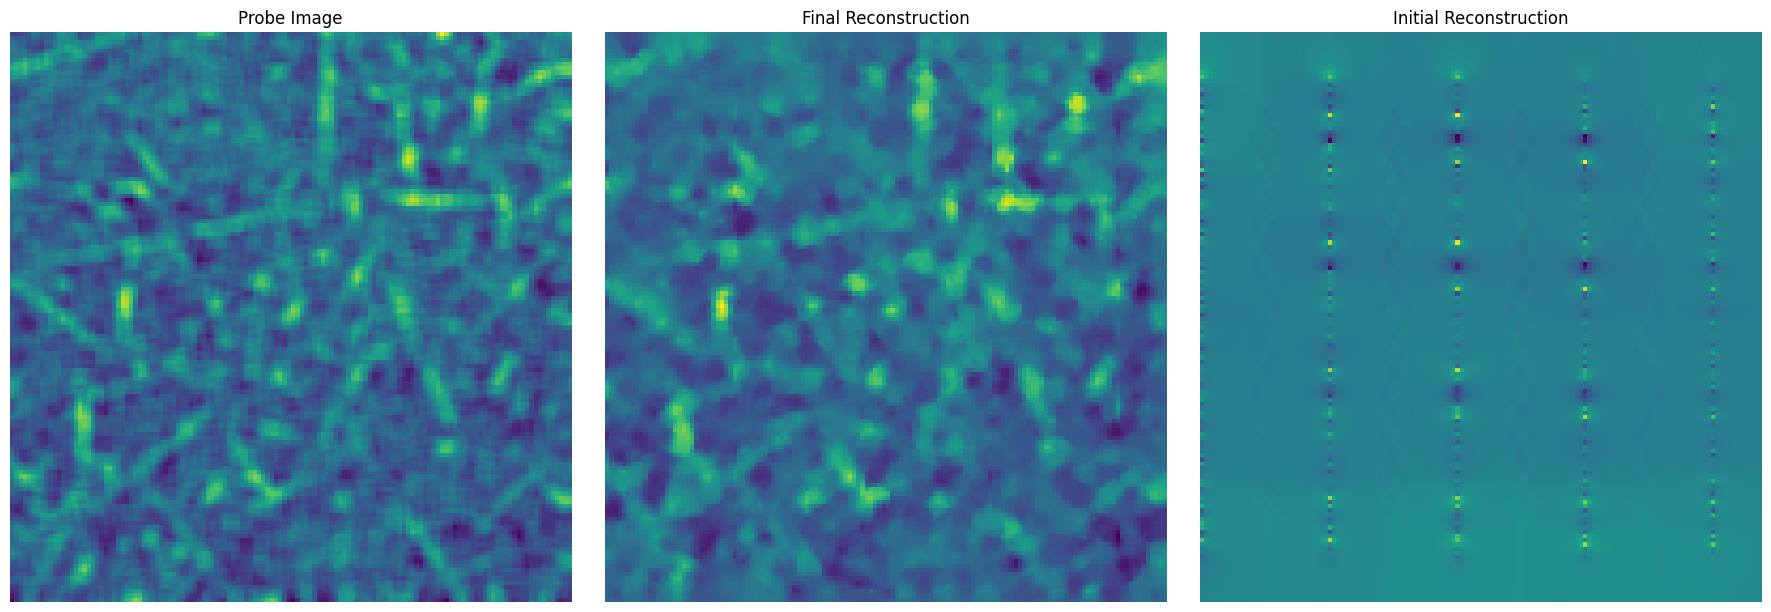

In [14]:
# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjusted size

# Show the original probe image for comparison
axs[0].imshow(probe_image)
axs[0].set_title("Probe Image")
axs[0].axis('off')

# Visualize the final reconstruction
axs[1].imshow(recon_final_np)
axs[1].set_title("Final Reconstruction")
axs[1].axis('off')


# Visualize the initial reconstruction
axs[2].imshow(initial_recon)
axs[2].set_title("Initial Reconstruction")
axs[2].axis('off')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all three plots in one row
plt.show()

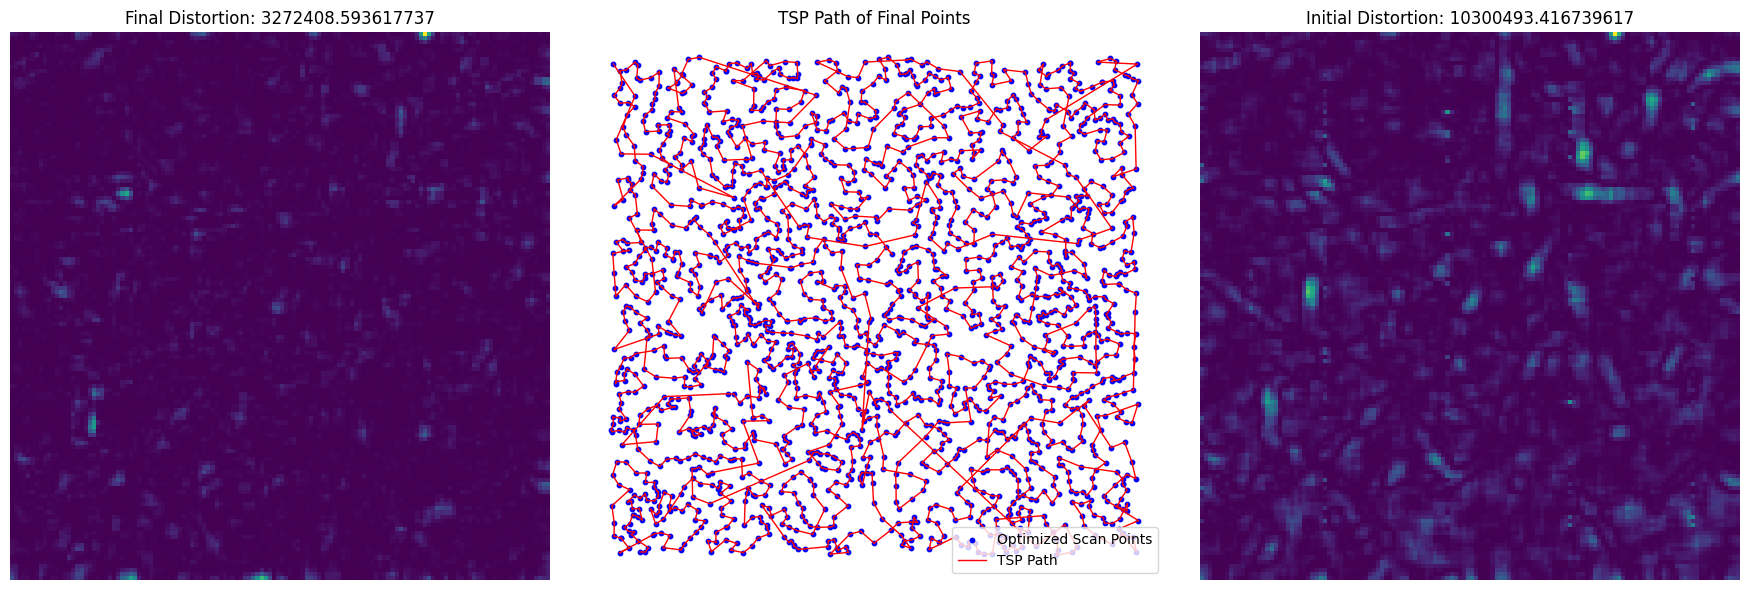

In [15]:
# Create a figure with 3 subplots in one row
points_final_np = points_final.detach().numpy()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjusted size

# Calculate and visualize the final distortion
axs[0].imshow(distortion_final)
axs[0].set_title(f"Final Distortion: {np.sum(distortion_final)}")
axs[0].axis('off')


# Plot 2: TSP Path of Final Points (Just the TSP Path connecting optimized points)
# Plot the optimized scan points
for i, (x, y) in enumerate(optimized_scan_points):
    axs[1].scatter(x, y, color='blue', s=10, label='Optimized Scan Points' if i == 0 else "")

# Plot the TSP path connecting the optimized scan points
for i in range(len(tsp_path) - 1):
    x_vals = [optimized_scan_points[tsp_path[i]][0], optimized_scan_points[tsp_path[i+1]][0]]
    y_vals = [optimized_scan_points[tsp_path[i]][1], optimized_scan_points[tsp_path[i+1]][1]]
    axs[1].plot(x_vals, y_vals, 'r-', lw=1, label='TSP Path' if i == 0 else "")

# Add title and legend to the second plot
axs[1].set_title("TSP Path of Final Points")
axs[1].legend()
axs[1].axis('off')


# Visualize the initial distortion
axs[2].imshow(distortion_before)
axs[2].set_title(f"Initial Distortion: {np.sum(distortion_before)}")
axs[2].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all three plots in one row
plt.show()

In [16]:
# Image dimensions
height, width = image.shape  # Assuming `image` is the 2D array of the image

# Total number of possible points in continuous space with 0.05 spacing
min_dist = 0.1
total_possible_points = (height * width) / (min_dist)

# Total number of filtered points from the optimal scan points and initial points
filtered_total_optimal_points = len(all_path_points)
filtered_total_initial_points = len(points_current)*10

# Calculate percentage of optimal points relative to the total possible continuous points
optimal_percentage = (filtered_total_optimal_points / total_possible_points) * 100
print(f"The filtered scan points represent {optimal_percentage:.2f}% of the total possible continuous points.")

# Calculate percentage of initial points relative to the total possible continuous points
initial_percentage = (filtered_total_initial_points / total_possible_points) * 100
print(f"The filtered initial points represent {initial_percentage:.2f}% of the total possible continuous points.")

# Calculate combined percentage of both initial and optimal points relative to the total possible continuous points
combined_points = filtered_total_optimal_points + filtered_total_initial_points
combined_percentage = (combined_points / total_possible_points) * 100
print(f"The combined filtered initial and optimal points represent {combined_percentage:.2f}% of the total possible continuous points.")



The filtered scan points represent 11.30% of the total possible continuous points.
The filtered initial points represent 3.22% of the total possible continuous points.
The combined filtered initial and optimal points represent 14.52% of the total possible continuous points.
